<a href="https://colab.research.google.com/github/YunHoLeee/FourPanelCartoon/blob/main/%EC%9B%B9%ED%88%B0%EC%97%B0%EA%B5%AC_%ED%86%A0%ED%94%BD%EB%AA%A8%EB%8D%B8%EB%A7%81_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 비지도학습 (토픽모델링)

In [ ]:
# # 나눔고딕 설치
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 패키지 설치
!pip install -U tomotopy gdown -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 20.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# # 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
# mpl.rcParams['axes.unicode_minus'] = False
# plt.rc('font', family='NanumBarunGothic')
# font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# import matplotlib.colors as clr

from collections import Counter
import regex
import re

# from kiwipiepy import Kiwi
# kiwi = Kiwi(model_type='sbg')

# from flashtext import KeywordProcessor
# kp = KeywordProcessor()

import tomotopy as tp
# print(tp.isa)
import sys
from sklearn import preprocessing

import itertools
from collections import defaultdict
import pickle

import nltk
from nltk import collocations
from gensim.test.utils import common_texts
# from gensim.models import Word2Vec
# from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gdown
import ast

Selecting previously unselected package fonts-nanum.
(Reading database ... 121913 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


<Figure size 500x500 with 0 Axes>

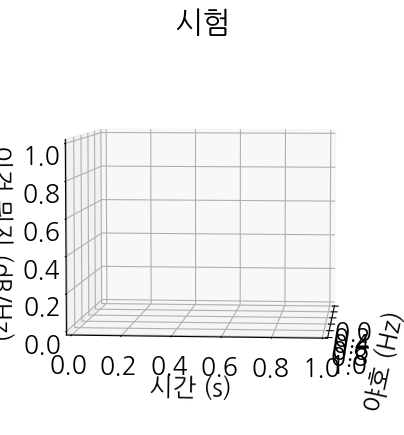

In [ ]:
# 시각화 필요 라이브러리 불러오기
import matplotlib.font_manager as fm
import os
import matplotlib.pyplot as plt

# apt-get : 패키지 설치 명령어
# -qq : 에러외의 메세지 숨기는 옵션키
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'}) # 폰트 설정

# 테스트 해보기
fig = plt.figure(figsize=(5, 5))
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(5, 5))

graph_title = '시험'
ax.set_title(f'{graph_title}')
ax.set_xlabel('야호 (Hz)', labelpad=10)
ax.set_ylabel('시간 (s)', labelpad=10)
ax.set_zlabel('이건 뭐지 (dB/Hz)', labelpad=10)

ax.view_init(5, 5)
plt.show()

### 데이터 준비
웹툰 관련 연구 전체(670건)

In [ ]:
# 내 연구 대상 논문 데이터(엑셀) load
# https://docs.google.com/spreadsheets/d/1VrIaWrdrJMlFDTPl8BkhF4U7CHzWwCV0WFpceRujC1w/edit?gid=0#gid=0
gdown.download(id='1VrIaWrdrJMlFDTPl8BkhF4U7CHzWwCV0WFpceRujC1w',output='webtoon.xlsx')
df = pd.read_excel('./webtoon.xlsx')

Downloading...
From (original): https://drive.google.com/uc?id=1VrIaWrdrJMlFDTPl8BkhF4U7CHzWwCV0WFpceRujC1w
From (redirected): https://docs.google.com/spreadsheets/d/1VrIaWrdrJMlFDTPl8BkhF4U7CHzWwCV0WFpceRujC1w/export?format=xlsx
To: /content/webtoon.xlsx
533kB [00:00, 6.12MB/s]


In [ ]:
df = pd.read_excel('./webtoon.xlsx') # 나중에 실습할때 여기에 여러분이 다운로드 받은 파일 이름으로 변경할 것.
df

,논문명,논문 ID,저자명,주저자 소속기관,학술지 ID,학술지명,저자키워드,초록,발행기관 ID,발행기관명,발행연도,대분류,중분류,종분류,URL,KCI 등재 구분
0,디지털 플랫폼 기업 M&A 전략의 경제․사회적 효과 분석: 카카오엔터테인먼트의 사례...,ART002937137,유병준;정연승;이정준;오예린,서울대학교,1117,Korea Business Review,"디지털 플랫폼, M&A, 디지털 콘텐츠, 카카오, 경제사회적 효과","본 연구는 카카오엔터테인먼트의 M&A 전략을 사례로 분석하여, 디지털 플랫폼 기업 ...",INS000000739,한국경영학회,2023,사회과학,경영학,경영교육,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
1,한국 웹툰 플랫폼의 섬네일 특징이 웹툰 선택에 미치는 영향: 이미지 분석을 적용하여,ART002995105,유승희;김호림;최진욱,이화여자대학교,1599,상품학연구,"웹툰, 섬네일, 이미지 분석, 콘텐츠, 한류",최근 한국의 웹툰은 원천 지식재산이자 한류 콘텐츠로서 급부상하며 산업적 가치가 높아...,INS000000807,한국상품학회,2023,사회과학,경영학,경영학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
2,창세신화를 활용한 문화적 리터러시 교육 방안 연구,ART002950050,변숙자,한국교원대학교,1465,청람어문교육,"문화적 리터러시, 문화교육, 고전문학, 창세신화, <천지왕본풀이>",본고는 고전문학 텍스트를 활용한 문화적 리터러시 교육의 실현 방안을 탐색하는 데 목...,INS000000267,청람어문교육학회,2023,인문학,문학,국어교육,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
3,만화에서 무배경이 유발하는 참여적 사유에 관한 담론,ART002950245,이용수,호서대학교,SER000000642,일러스트레이션 포럼,"만화/웹툰, 무배경, 참여적 사유","본고는 만화/웹툰 이미지를 분석하는 데에 있어서, 배경이 묘사되어 있는가 없는가 하...",INS000000241,한국일러스트레이션학회,2023,예술체육학,디자인,디자인,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
4,웹툰 이용에 따른 행위중독성 연구,ART003018786,박미라,성결대학교,2029,신학과 실천,"웹툰, 행위중독, 스마트폰 과의존, 이용동기, 감각추구",본 연구에서는 코로나19이후 증가된 웹툰 이용에 있어서 과의존 및 중독적 경향에 관...,INS000001585,한국실천신학회,2023,인문학,기독교신학,기독교신학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
665,인터넷 언어 문화 교육 내용으로서 디지털 서사의 개념 특성 유형에 관한 연구,ART001227261,정현선,경인교육대학교,1205,국어교육학연구,"인터넷, 기호, 소통, 디지털 서사, 인터넷 소설, 팬픽, 웹툰, 하이퍼텍스트 서사...",인터넷 언어 문화 교육 내용으로서디지털 서사의 개념특성유형에 관한 연구정현선본고는 ...,INS000001358,국어교육학회,2007,인문학,한국어와문학,한국어와문학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재
666,웹 만화 <위대한 캣츠비>의 스토리텔링 구조 분석,ART001061496,이상민,가톨릭대학교,1717,대중서사연구,"위대한 캣츠비, 웹 만화, 스토리텔링, 웹 미디어의 특징, 서사적 층위","웹 만화 위대한 캣츠비는 웹의 매체를 이용한 서정성 획득, 3중 구조에 따른 서사적...",INS000000103,대중서사학회,2007,복합학,학제간연구,학제간연구,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재후보
667,디지털 컨텐츠 산업과 디지털 만화에 관한 연구,ART001039099,고은나,부천대학,SER000000642,일러스트레이션 포럼,NaN,디지털 기술의 발전은 사회문화 전반에 큰 파장을 일으키며 디지털 컨텐츠 산업을 빠른...,INS000000241,한국일러스트레이션학회,2006,예술체육학,디자인,디자인,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재후보
668,디지털 만화 콘텐츠 메타데이터 요소개발 및 적용,ART001203563,오상훈;조현주;이용배;강지훈;맹성현,명지대학교,D00564,정보처리학회논문지D,"메타데이터요소(Metadata Element), 디지털콘텐츠 유통기술(DRM), 디...","디지털콘텐츠 서비스 유형이 다양해지면서 콘텐츠 유통에 참여하는 주체들(저작자, 가공...",INS000000930,한국정보처리학회,2004,공학,정보 없음,공학,https://www.kci.go.kr/kciportal/ci/sereArticle...,등재


In [ ]:
# 컬럼 확인
df.columns

Index(['논문명', '논문 ID', '저자명', '주저자 소속기관', '학술지 ID', '학술지명', '저자키워드', '초록',
       '발행기관 ID', '발행기관명', '발행연도', '대분류', '중분류', '종분류', 'URL', 'KCI 등재 구분'],
      dtype='object')

In [ ]:
# 이미 키워드가 제공됨.
df['저자키워드']

0                   디지털 플랫폼, M&A, 디지털 콘텐츠, 카카오, 경제사회적 효과
1                               웹툰, 섬네일, 이미지 분석, 콘텐츠, 한류
2                   문화적 리터러시, 문화교육, 고전문학, 창세신화, <천지왕본풀이>
3                                     만화/웹툰, 무배경, 참여적 사유
4                         웹툰, 행위중독, 스마트폰 과의존, 이용동기, 감각추구
                             ...                        
665    인터넷, 기호, 소통, 디지털 서사, 인터넷 소설, 팬픽, 웹툰, 하이퍼텍스트 서사...
666              위대한 캣츠비, 웹 만화, 스토리텔링, 웹 미디어의 특징, 서사적 층위
667                                                  NaN
668    메타데이터요소(Metadata Element), 디지털콘텐츠 유통기술(DRM), 디...
669                             DRM, 만화 콘텐츠, 유통 모델, 시나리오
Name: 저자키워드, Length: 670, dtype: object

In [ ]:
# 키워드 빈칸 삭제
df = df.dropna(subset='저자키워드').reset_index(drop=True)

In [ ]:
# 키워드 컬럼 string -> list
df['token'] = df['저자키워드'].str.split(',')
df['token']

0             [디지털 플랫폼,  M&A,  디지털 콘텐츠,  카카오,  경제사회적 효과]
1                         [웹툰,  섬네일,  이미지 분석,  콘텐츠,  한류]
2             [문화적 리터러시,  문화교육,  고전문학,  창세신화,  <천지왕본풀이>]
3                                 [만화/웹툰,  무배경,  참여적 사유]
4                   [웹툰,  행위중독,  스마트폰 과의존,  이용동기,  감각추구]
                             ...                        
663                                   [만화,  만화산업,  만화정책]
664    [인터넷,  기호,  소통,  디지털 서사,  인터넷 소설,  팬픽,  웹툰,  하...
665        [위대한 캣츠비,  웹 만화,  스토리텔링,  웹 미디어의 특징,  서사적 층위]
666    [메타데이터요소(Metadata Element),  디지털콘텐츠 유통기술(DRM),...
667                        [DRM,  만화 콘텐츠,  유통 모델,  시나리오]
Name: token, Length: 668, dtype: object

In [ ]:
# 이미 키워드가 제공됨.
df['초록']

0      본 연구는 카카오엔터테인먼트의 M&A 전략을 사례로 분석하여, 디지털 플랫폼 기업 ...
1      최근 한국의 웹툰은 원천 지식재산이자 한류 콘텐츠로서 급부상하며 산업적 가치가 높아...
2      본고는 고전문학 텍스트를 활용한 문화적 리터러시 교육의 실현 방안을 탐색하는 데 목...
3      본고는 만화/웹툰 이미지를 분석하는 데에 있어서, 배경이 묘사되어 있는가 없는가 하...
4      본 연구에서는 코로나19이후 증가된 웹툰 이용에 있어서 과의존 및 중독적 경향에 관...
                             ...                        
665    인터넷 언어 문화 교육 내용으로서디지털 서사의 개념특성유형에 관한 연구정현선본고는 ...
666    웹 만화 위대한 캣츠비는 웹의 매체를 이용한 서정성 획득, 3중 구조에 따른 서사적...
667    디지털 기술의 발전은 사회문화 전반에 큰 파장을 일으키며 디지털 컨텐츠 산업을 빠른...
668    디지털콘텐츠 서비스 유형이 다양해지면서 콘텐츠 유통에 참여하는 주체들(저작자, 가공...
669    현재 디지털 만화 컨텐츠의 온라인상에서의 유통은 불법유통 및 저작권 보호체계의 미비...
Name: 초록, Length: 670, dtype: object

In [ ]:
# 키워드 빈칸 삭제
df = df.dropna(subset='초록').reset_index(drop=True)

In [ ]:
# 키워드 컬럼 string -> list
df['token'] = df[{('키워드'), ('초록')}].str.split(',')
df['token']

TypeError: Passing a set as an indexer is not supported. Use a list instead.

In [ ]:
df['token'] = df['저자키워드'].str.split(',')

In [ ]:
# 제외할 키워드 목록
exclude_keywords = {'Webtoon(웹툰)', '디지털 만화', '웹 코믹스', '인터넷 만화', '온라인 만화''웹툰', '웹만화', '디지털만화', '웹코믹스', '인터넷만화', '온라인만화', 'webtoon', '만화', 'Webtoon'}

In [ ]:
def replace_spaces_with_hyphens(저자키워드):
  """
  저자키워드 리스트에서 공백을 하이픈으로 바꿔줍니다.

  Args:
    저자키워드: 저자키워드 문자열 리스트

  Returns:
    공백이 하이픈으로 대체된 문자열 리스트
  """

  업데이트된_키워드 = []
  for 키워드 in 저자키워드:
    업데이트된_키워드.append(키워드.replace(" ", "-"))
  return 업데이트된_키워드

# 예시
저자키워드 = ["기계 학습", "자연어 처리", "심층 학습"]
업데이트된_키워드 = replace_spaces_with_hyphens(저자키워드)
print(업데이트된_키워드)

['기계-학습', '자연어-처리', '심층-학습']


In [ ]:
# 키워드 리스트에서 제외할 키워드 제거
df['token'] = df['token'].apply(lambda tokens: [token.strip() for token in tokens if token.strip() not in exclude_keywords])

### 1. LDA
"청년 담론 분석"  
https://bab2min.github.io/tomotopy

##### 모델 초기화

In [ ]:
# 일반 LDA. 파라미터가 중요한데 k값이 토픽의 개수로, 토픽 개수를 정하는 기준도 있음.
# 토픽 개수에 따라 결과 차이가 큼. tw는 단어의 경중을 따지는 것으로, pmi는 단순빈도보다 중요
# nn_top은 상위 몇개를 지울 것인지. '웹툰'으로 하면 '웹툰'이 1위이기 때문에 지우는 방식임.
LDA = tp.LDAModel(k=9,min_df=3,tw=tp.TermWeight.PMI,rm_top=3, seed=2022) # Hyperparameter 숙지 필수

##### 빈 모델에 토큰 리스트 넣어주기

In [ ]:
for token in tqdm(df['token'].tolist()):
    LDA.add_doc(token)

  0%|          | 0/668 [00:00<?, ?it/s]

##### 모델 학습

In [ ]:
# 학습 준비
LDA.train(0)

<ipython-input-86-f63eeebc9d98>:2: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA.train(0)


In [ ]:
# 한번에 20회씩 총 500회 학습
print('Num docs:', len(LDA.docs), ', Vocab size:', LDA.num_vocabs, ', Num words:', LDA.num_words)
print('Removed top words:', LDA.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    LDA.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, LDA.ll_per_word))

Training...


Num docs: 668 , Vocab size: 126 , Num words: 556
Removed top words: ['웹툰', '스토리텔링', '문화콘텐츠']
Iteration: 0	Log-likelihood: -3.605147834186558
Iteration: 20	Log-likelihood: -3.5606693290203206
Iteration: 40	Log-likelihood: -3.5600007054451965
Iteration: 60	Log-likelihood: -3.546828067608281
Iteration: 80	Log-likelihood: -3.537208422625207
Iteration: 100	Log-likelihood: -3.5218890803991707
Iteration: 120	Log-likelihood: -3.524637235852881
Iteration: 140	Log-likelihood: -3.502767705964891
Iteration: 160	Log-likelihood: -3.5155493116583023
Iteration: 180	Log-likelihood: -3.5161125016064068
Iteration: 200	Log-likelihood: -3.511879254093859
Iteration: 220	Log-likelihood: -3.498910466563405
Iteration: 240	Log-likelihood: -3.491595131553789
Iteration: 260	Log-likelihood: -3.5162825252962504
Iteration: 280	Log-likelihood: -3.5274662518948885
Iteration: 300	Log-likelihood: -3.511146886465495


<ipython-input-87-2cacfe4b8176>:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA.train(20)


Iteration: 320	Log-likelihood: -3.511652194147764
Iteration: 340	Log-likelihood: -3.485468811980037
Iteration: 360	Log-likelihood: -3.482839505791876
Iteration: 380	Log-likelihood: -3.513241759992108
Iteration: 400	Log-likelihood: -3.4764534210892535
Iteration: 420	Log-likelihood: -3.500317083603654
Iteration: 440	Log-likelihood: -3.4791767531631046
Iteration: 460	Log-likelihood: -3.5028988449798657
Iteration: 480	Log-likelihood: -3.4883297287182717


In [ ]:
# 학습 결과
LDA.summary()

<Basic Info>
| LDAModel (current version: 0.12.7)
| 668 docs, 556 words
| Total Vocabs: 2503, Used Vocabs: 126
| Entropy of words: 4.70823
| Entropy of term-weighted words: 4.76416
| Removed Vocabs: 웹툰 스토리텔링 문화콘텐츠
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -3.48833
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 3 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 9 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 2022 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.0097097  

##### 토픽별 TopN 단어 확인

In [ ]:
for i in range(LDA.k):
    res = LDA.get_topic_words(i, top_n=6) # top 10
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Topic #0	캐릭터, OSMU, 신과 함께, 매체전환, 트랜스미디어, 영화
Topic #1	만화산업, 웹툰교육, 모바일, 웹툰 작가, 만화교육, 사용자 경험
Topic #2	트랜스미디어 스토리텔링, 가상현실, 세계관, 인터랙션, 애니메이션, OTT
Topic #3	상호작용성, 환상성, 공존, 매체 전환, 문화소, 고전문학
Topic #4	웹소설, 플랫폼, 콘텐츠, 번역, 한류, 웹툰산업
Topic #5	일상툰, 재매개, 인스타툰, 세로 스크롤, 독자, 매체
Topic #6	서사, 재매개, 미생, 신과함께, 공간, 비매개
Topic #7	브랜드 웹툰, 브랜드웹툰, 제품유형, 광고, 브랜디드 콘텐츠, 구매의도
Topic #8	웹툰 플랫폼, 좀비, 상호텍스트성, 미디어, 전자책, 학원물


##### 토픽 이름 자동으로 붙이기 (참고용)

In [ ]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=10, max_len=5, max_cand=10000)
cands = extractor.extract(LDA)

labeler = tp.label.FoRelevance(LDA, cands, min_df=10, smoothing=1e-2, mu=0.25)
for k in range(LDA.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in LDA.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 문화콘텐츠, 캐릭터, 스토리텔링, 신과 함께, OSMU
서사	0.3144398033618927
바리공주	0.2863622009754181
강풀	0.20313586294651031
문화콘텐츠	0.1901099979877472
OSMU	0.00010451095295138657
가상현실	0.00010443626524647698
웹툰 작가	0.00010443128121551126
웹툰산업	0.00010443128121551126
세로 스크롤	0.00010442630446050316
트랜스미디어	0.00010442630446050316

== Topic #1 ==
Labels: 콘텐츠, 트랜스미디어, 캐릭터, 재매개, OSMU
콘텐츠	0.3021845519542694
플랫폼	0.20878010988235474
한류	0.1570514440536499
웹툰산업	0.1482982337474823
전자책	0.14275729656219482
네이버	0.03692949563264847
OSMU	7.28793311282061e-05
브랜드 웹툰	7.271639333339408e-05
가상현실	7.271292997756973e-05
트랜스미디어	7.270945934578776e-05

== Topic #2 ==
Labels: 일상툰, 스토리텔링, 콘텐츠, 신과 함께, 웹소설
일상툰	0.1953059732913971
좀비	0.175524041056633
대중문화	0.16979925334453583
인스타툰	0.15826568007469177
웹툰 작가	0.15204398334026337
매체	0.1449839025735855
콘텐츠	7.418711174977943e-05
문화콘텐츠	7.415530126309022e-05
공감	7.413762796204537e-05
가상현실	7.413409184664488e-05

== Topic #3 ==
Labels: 재매개, 트랜스미디어 스토리텔링, 문화콘텐츠, 콘텐츠, 웹소설
재매개	0.2867369949

### 2. DTM (Dynamic Topic Model)
"시간의 변화에 따른 청년 담론의 변화"

In [ ]:
df['발행연도'].astype(str)

0      2023
1      2023
2      2023
3      2023
4      2023
       ... 
663    2007
664    2007
665    2007
666    2004
667    2003
Name: 발행연도, Length: 668, dtype: object

In [ ]:
# 연도 컬럼 추가
df['year']=df['발행연도'].astype(str).str.slice(start=0,stop=4)
df['year']

0      2023
1      2023
2      2023
3      2023
4      2023
       ... 
663    2007
664    2007
665    2007
666    2004
667    2003
Name: year, Length: 668, dtype: object

In [ ]:
df['year'].value_counts()

year
2023    101
2022     87
2021     67
2019     64
2018     61
2020     59
2015     50
2017     49
2016     41
2014     29
2011     14
2012     13
2013     12
2010      7
2009      5
2007      5
2008      2
2004      1
2003      1
Name: count, dtype: int64

In [ ]:
# DTM에서 t(시간 하이퍼하라미터) 형식으로 변환(0부터 시작)
df['year'] = df['year'].astype(int) - 2003

In [ ]:
# 0 : 2021, 1:2022, 2:2023
df['year'].value_counts()

year
20    101
19     87
18     67
16     64
15     61
17     59
12     50
14     49
13     41
11     29
8      14
9      13
10     12
7       7
6       5
4       5
5       2
1       1
0       1
Name: count, dtype: int64

### 일단 해보자

In [ ]:
import pandas as pd
import tomotopy as tp
from tqdm import tqdm

# Load the newly uploaded Excel file
file_path = 'webtoon.xlsx'  # Replace with your file path
df = pd.read_excel(file_path, sheet_name='서지정보')

# Drop rows with NaN in '저자키워드' or '초록' columns
df = df.dropna(subset=['저자키워드', '초록']).reset_index(drop=True)

# Define the list of stopwords to remove from '저자키워드'
additional_stopwords = set([
    '웹툰', '웹만화', '디지털만화', '웹코믹스', '인터넷만화', '온라인만화', 'webtoon'
])

# Function to preprocess '저자키워드' and remove stopwords
def preprocess_keywords(keywords):
    if isinstance(keywords, str):
        keywords = keywords.split(',')
        keywords = [kw for kw in keywords if kw not in additional_stopwords]
        return ' '.join(keywords)
    return ''

# Apply the function to the '저자키워드' column
df['processed_keywords'] = df['저자키워드'].apply(preprocess_keywords)

# Add 'year' column
df['year'] = df['발행연도'].astype(str).str.slice(start=0, stop=4)
df['year'] = df['year'].astype(int)

# Map the years to the specified ranges
def map_year_to_period(year):
    if 2003 <= year <= 2010:
        return 0
    elif 2011 <= year <= 2013:
        return 1
    elif 2014 <= year <= 2021:
        return 2
    elif 2022 <= year <= 2023:
        return 3
    return -1  # For any unexpected year values

df['period'] = df['year'].apply(map_year_to_period)

# Convert the processed keywords to token lists
df['token'] = df['processed_keywords'].apply(lambda x: x.split())

# Prepare the data for DTM
token_year_dict = df[['token', 'period']].to_dict('index')

# Initialize the DTM model
DTM = tp.DTModel(k=10, min_df=10, tw=tp.TermWeight.PMI, t=4, rm_top=3, seed=2023)  # Updated 't' to 4 to match the number of periods

# Add documents to the DTM model
for k in tqdm(token_year_dict.keys()):
    tokens = token_year_dict[k]['token']
    timepoint = token_year_dict[k]['period']
    if timepoint != -1:  # Only add valid periods
        DTM.add_doc(tokens, timepoint)

# Train the DTM model
DTM.burn_in = 100
DTM.train(0)
for i in range(1000):
    DTM.train(10)
    if i % 10 == 0:
        print(f'Iteration: {i}, Log-likelihood: {DTM.ll_per_word}')

# Extract topics and their evolution
for k in range(DTM.k):
    print(f'Topic #{k}')
    for t in range(DTM.num_timepoints):
        print(f'Timepoint {t}: ', DTM.get_topic_words(k, top_n=10, timepoint=t))

# 토픽의 비율을 시간에 따라 시각화하는 함수
def plot_topic_proportions(model, num_topics, num_timepoints):
    proportions = []
    for t in range(num_timepoints):
        timepoint_proportions = []
        for k in range(num_topics):
            # Use get_count_by_topics with correct parameters
            timepoint_proportions.append(model.get_count_by_topics(k)[t])
        proportions.append(timepoint_proportions)

    proportions = np.array(proportions).T

    for k in range(num_topics):
        plt.plot(range(num_timepoints), proportions[k], label=f'Topic {k}')

    plt.xlabel('Timepoint')
    plt.ylabel('Proportion')
    plt.legend()
    plt.show()

# DTM 모델의 토픽 비율 시각화
plot_topic_proportions(DTM, DTM.k, DTM.num_timepoints)

100%|██████████| 670/670 [00:00<00:00, 87563.76it/s]
<ipython-input-23-dee3f318cb86>:64: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(0)
<ipython-input-23-dee3f318cb86>:66: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(10)


Iteration: 0, Log-likelihood: -2.228269828661353
Iteration: 10, Log-likelihood: -2.235873079510101
Iteration: 20, Log-likelihood: -2.2211549300048454
Iteration: 30, Log-likelihood: -2.2223038682189147
Iteration: 40, Log-likelihood: -2.221325606074915
Iteration: 50, Log-likelihood: -2.2172655130738077
Iteration: 60, Log-likelihood: -2.2179643690941937
Iteration: 70, Log-likelihood: -2.2368238738397066
Iteration: 80, Log-likelihood: -2.2268498575703863
Iteration: 90, Log-likelihood: -2.245156797203515
Iteration: 100, Log-likelihood: -2.212425100534872
Iteration: 110, Log-likelihood: -2.2256704059929113
Iteration: 120, Log-likelihood: -2.230729675002965
Iteration: 130, Log-likelihood: -2.218286209422562
Iteration: 140, Log-likelihood: -2.2217139267190666
Iteration: 150, Log-likelihood: -2.2306737837830526
Iteration: 160, Log-likelihood: -2.2309731169268976
Iteration: 170, Log-likelihood: -2.2149488139368647
Iteration: 180, Log-likelihood: -2.2185453226231675
Iteration: 190, Log-likelihood

TypeError: DTModel.get_count_by_topics() takes no arguments (1 given)

In [ ]:
# 학습 결과
DTM.summary()

<Basic Info>
| DTModel (current version: 0.12.7)
| 668 docs, 167 words
| Total Vocabs: 2433, Used Vocabs: 12
| Entropy of words: 2.47217
| Entropy of term-weighted words: 2.47786
| Removed Vocabs: 만화 스토리텔링 Webtoon
|
<Training Info>
| Iterations: 10000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -2.21483
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| t: 4 (the number of timpoints)
| alpha_var: 0.1 (transition variance of alpha (per-document topic distribution))
| eta_var: 0.1 (variance of eta (topic distribution of each document) from its alpha )
| phi_var: 0.1 (transition variance of phi (word distribution of each topic))
| lr_a: 0.01 (shape parameter `a` greater than zero, for SGLD step size calculated as `e_i = a * (b + i) ^ (-c)`)
| lr_b: 0.1 (shape par

In [ ]:
import pandas as pd

# Example topic evolution data from the DTM results
topics = {
    0: [0, 1, 5, 8],
    1: [1, 3, 11, 5],
    2: [0, 0, 11, 2],
    3: [0, 0, 13, 5],
    4: [0, 1, 15, 3],
    5: [1, 0, 7, 5],
    6: [2, 1, 9, 5],
    7: [0, 0, 17, 6],
    8: [1, 0, 10, 2],
    9: [0, 0, 12, 5],
}

timepoints = ['2003-2010', '2011-2013', '2014-2021', '2022-2023']

# Create a DataFrame for the topic proportions
topic_df = pd.DataFrame(topics, index=timepoints)

# Display the DataFrame
print(topic_df)

# Save the DataFrame to an Excel file
output_file_path = 'topic_proportions_by_time_period.xlsx'
topic_df.to_excel(output_file_path, index=True)


           0   1   2   3   4  5  6   7   8   9
2003-2010  0   1   0   0   0  1  2   0   1   0
2011-2013  1   3   0   0   1  0  1   0   0   0
2014-2021  5  11  11  13  15  7  9  17  10  12
2022-2023  8   5   2   5   3  5  5   6   2   5


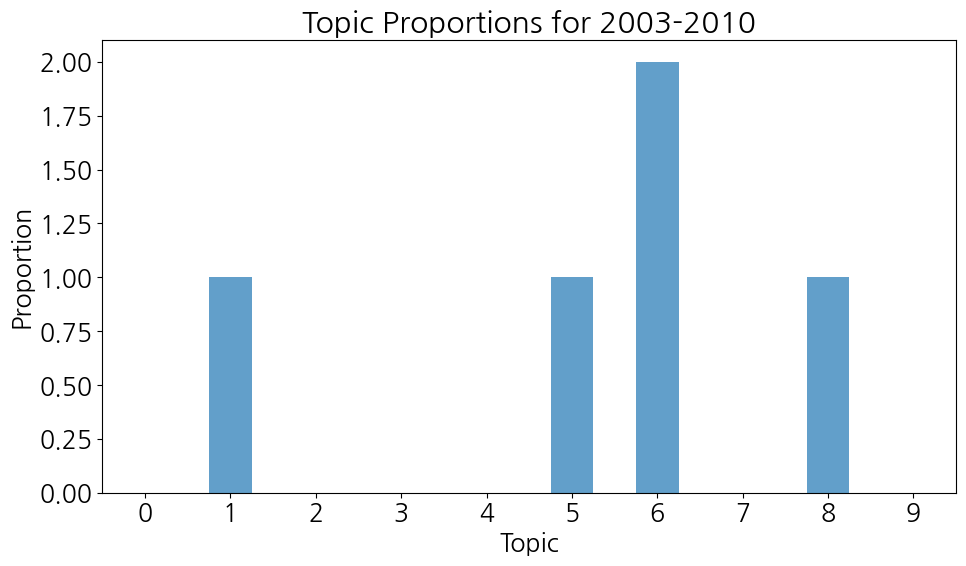

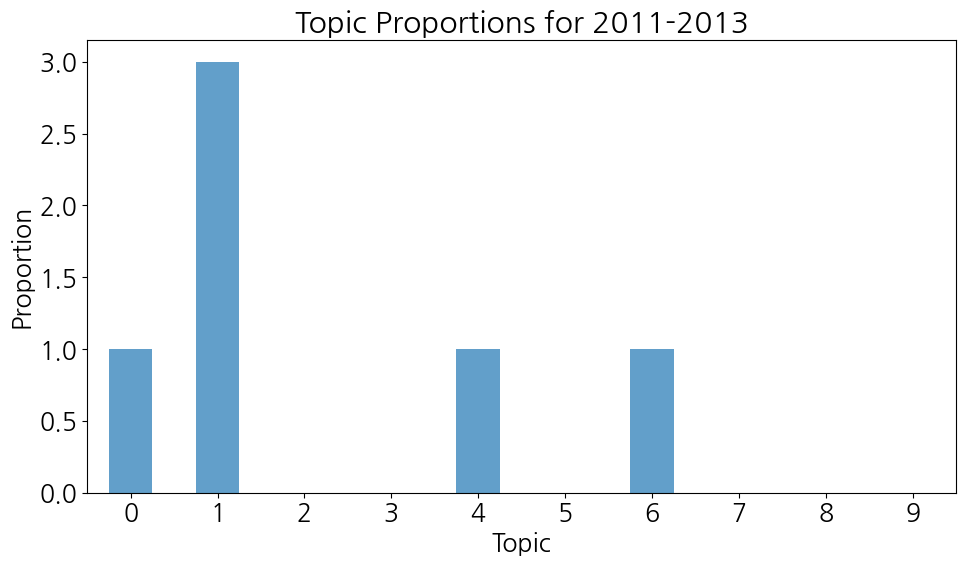

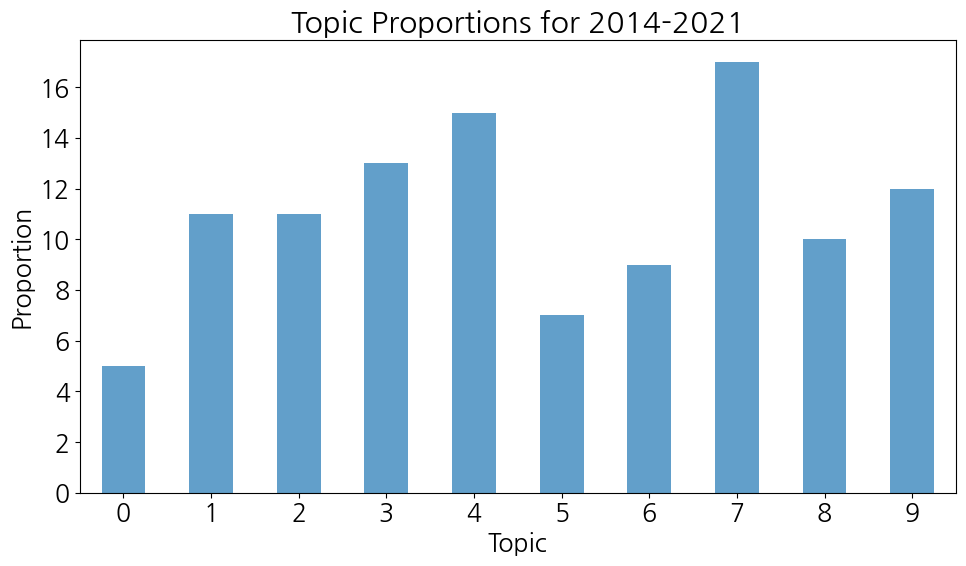

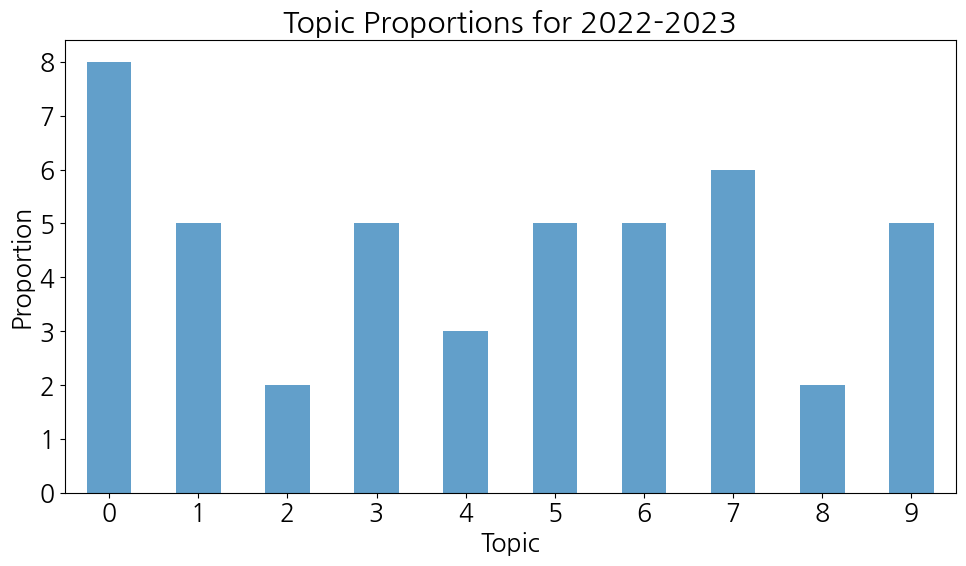

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example topic evolution data from the DTM results
topics = {
    0: [0, 1, 5, 8],
    1: [1, 3, 11, 5],
    2: [0, 0, 11, 2],
    3: [0, 0, 13, 5],
    4: [0, 1, 15, 3],
    5: [1, 0, 7, 5],
    6: [2, 1, 9, 5],
    7: [0, 0, 17, 6],
    8: [1, 0, 10, 2],
    9: [0, 0, 12, 5],
}

timepoints = ['2003-2010', '2011-2013', '2014-2021', '2022-2023']

# Create a DataFrame for the topic proportions
topic_df = pd.DataFrame(topics, index=timepoints)

# Plotting the topic proportions for each time period separately
for i, timepoint in enumerate(timepoints):
    plt.figure(figsize=(10, 6))
    topic_df.iloc[i].plot(kind='bar', colormap='tab20', alpha=0.7)
    plt.title(f'Topic Proportions for {timepoint}')
    plt.xlabel('Topic')
    plt.ylabel('Proportion')
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Save each plot as a separate image file
    output_image_path = f'topic_proportions_{timepoint}.png'
    plt.savefig(output_image_path)

    # Display the plot
    plt.show()


In [ ]:
import matplotlib.pyplot as plt

# 각 토픽의 시간에 따른 변화를 시각화
topic_evolution = {k: [] for k in range(DTM.k)}

for t in range(DTM.num_timepoints):
    for k in range(DTM.k):
        topic_words = DTM.get_topic_words(k, top_n=10, timepoint=t)
        topic_evolution[k].append(topic_words)

# 예시: 첫 번째 토픽의 시간에 따른 변화 시각화
for k, words in topic_evolution.items():
    print(f'Topic #{k}')
    for t, word_list in enumerate(words):
        print(f'Timepoint {t}: {word_list}')

# 토픽의 비율을 시간에 따라 시각화하는 함수
def plot_topic_proportions(model, num_topics, num_timepoints):
    proportions = []
    for t in range(num_timepoints):
        timepoint_proportions = []
        for k in range(num_topics):
            timepoint_proportions.append(sum(model.get_count_by_topics(k, timepoint=t)))
        proportions.append(timepoint_proportions)

    proportions = np.array(proportions).T

    for k in range(num_topics):
        plt.plot(range(num_timepoints), proportions[k], label=f'Topic {k}')

    plt.xlabel('Timepoint')
    plt.ylabel('Proportion')
    plt.legend()
    plt.show()

# DTM 모델의 토픽 비율 시각화
plot_topic_proportions(DTM, DTM.k, DTM.num_timepoints)


Topic #0
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #1
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #2
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #3
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #4
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #5
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #6
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #7
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #8
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []
Topic #9
Timepoint 0: []
Timepoint 1: []
Timepoint 2: []
Timepoint 3: []


TypeError: DTModel.get_count_by_topics() takes no keyword arguments

##### 모델 초기화

In [ ]:
# t = 3 이면 3개의 시기에 대한 DTM
DTM = tp.DTModel(k=10,min_df=10,tw=tp.TermWeight.PMI,t=4,rm_top=3, seed=2023) # 이번엔 PMI

##### 빈 모델에 토큰 리스트와 시간변수 넣어주기

In [ ]:
token_year_dict = df[['token','year']].to_dict('index')

KeyError: "['season'] not in index"

In [ ]:
for k in tqdm(token_year_dict.keys()):
    DTM.add_doc(token_year_dict[k]['token'],token_year_dict[k]['year'])

  0%|          | 0/670 [00:00<?, ?it/s]


KeyError: 'year'

##### 모델 학습

In [ ]:
# 학습 준비
DTM.train(0)

<ipython-input-28-1e51450c568d>:2: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(0)


In [ ]:
# 한번에 20회씩 총 500회 학습
print('Num docs:', len(DTM.docs), ', Vocab size:', DTM.num_vocabs, ', Num words:', DTM.num_words)
print('Removed top words:', DTM.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    DTM.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, DTM.ll_per_word))

Training...


Num docs: 4293 , Vocab size: 7143 , Num words: 697124
Removed top words: ['청년', '지원', '청년들']


<ipython-input-29-82b1bd76fb40>:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DTM.train(20)


Iteration: 0	Log-likelihood: -10.619397421508518
Iteration: 20	Log-likelihood: -10.480239789735135
Iteration: 40	Log-likelihood: -10.34439294625252
Iteration: 60	Log-likelihood: -10.21105128207192
Iteration: 80	Log-likelihood: -10.078347234425179
Iteration: 100	Log-likelihood: -9.957610298510374
Iteration: 120	Log-likelihood: -9.842536405884974
Iteration: 140	Log-likelihood: -9.738250474837134
Iteration: 160	Log-likelihood: -9.641060626290018
Iteration: 180	Log-likelihood: -9.550622300750309
Iteration: 200	Log-likelihood: -9.46786546141287
Iteration: 220	Log-likelihood: -9.39215395564002
Iteration: 240	Log-likelihood: -9.325857446494531
Iteration: 260	Log-likelihood: -9.262964052595871
Iteration: 280	Log-likelihood: -9.205074269862905
Iteration: 300	Log-likelihood: -9.153056429687004
Iteration: 320	Log-likelihood: -9.10672920834332
Iteration: 340	Log-likelihood: -9.062193698948795
Iteration: 360	Log-likelihood: -9.021545188286243
Iteration: 380	Log-likelihood: -8.985728676635423
Iterat

In [ ]:
# 학습 결과
DTM.summary()

<Basic Info>
| DTModel (current version: 0.12.7)
| 4293 docs, 697124 words
| Total Vocabs: 63776, Used Vocabs: 7143
| Entropy of words: 7.86104
| Entropy of term-weighted words: 8.30235
| Removed Vocabs: 청년 지원 청년들
|
<Training Info>
| Iterations: 500, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -8.84127
|
<Initial Parameters>
| tw: TermWeight.PMI
| min_cf: 0 (minimum collection frequency of words)
| min_df: 10 (minimum document frequency of words)
| rm_top: 3 (the number of top words to be removed)
| k: 10 (the number of topics between 1 ~ 32767)
| t: 3 (the number of timpoints)
| alpha_var: 0.1 (transition variance of alpha (per-document topic distribution))
| eta_var: 0.1 (variance of eta (topic distribution of each document) from its alpha )
| phi_var: 0.1 (transition variance of phi (word distribution of each topic))
| lr_a: 0.01 (shape parameter `a` greater than zero, for SGLD step size calculated as `e_i = a * (b + i) ^ (-c)`)
| lr_b: 0.1 (shape paramet

##### 토픽별 TopN 단어 확인

In [ ]:
for i in range(DTM.k):
    for t in range(3):
        res = DTM.get_topic_words(i,t,top_n=10)
        print('Topic #{}'.format(i), end='\t')
        print(', '.join(w for w, p in res))

Topic #0	가구, 월세, 총장, A씨, 사고, 피해자, 아버지, 사건, 간병, 통장
Topic #0	가입, 신청, 소득, 예산, 월세, 적금, 청년희망적금, 은행, 정부, 대통령실
Topic #0	대통령, 일본, 양국, 정부, 세대, 광주, 미래, 지역, 대통령실, 혁신
Topic #1	의원, 지사, 지급, 공약, 기본, 소득, 캠프, 이재명, 대선, 경기도
Topic #1	자립, 서울시, 고용, 아동, 준비, 지급, 시설, 복지, 1인, 영화
Topic #1	요금, 데이터, 대회, 탈모, 요금제, 혜택, 청년도약계좌, 출시, 가입, 제공
Topic #2	일자리, 기업, 프로젝트, 정부, 고용, 채용, 회장, 창출, 사업, 중소기업
Topic #2	당선인, 기업, 부산, 사업, 부산시, 선정, 공간, 임금, 가족, 장관
Topic #2	가족, 공간, 이스라엘, 정책, 문화, 부산, 토사물, 작품, 주민, 인간
Topic #3	주택, 공급, 채용, 주거, 코로나19, 신혼부부, 임대, 부동산, 가구, 공공
Topic #3	주택, 공급, 가구, 농업, 분양, 공공, 임대, 스마트, 청약, 신혼부부
Topic #3	취업, 주택, 채용, 공급, 임대, 프로그램, 신혼부부, 기관, 농업, 해외
Topic #4	교육, 사업, 서울시, 분야, 프로그램, 예산, 인재, 스타트업, 기후, 참여
Topic #4	취업, 일자리, 기업, 교육, 프로그램, 인재, 대학, 운영, 채용, 산업
Topic #4	노조, 노동자, 의원, 시간, 금리, 노동, 은행, 의견, 인재, 정부
Topic #5	후보, 대표, 국민, 세대, 정치, 민주당, 선대위, 대선, 선거, 이준석
Topic #5	후보, 대표, 정치, 대선, 대통령, 위원장, 국민, 선거, 민주당, 여성
Topic #5	고립, 은둔, 민주당, 의원, 정치, 국민, 대표, 최고, 현수막, 정치인
Topic #6	여성, 지역, 남성, 문화, 미얀마, 공간, 사회, 장애인, 백신, 시민
Topic #6	지역, 지방, 인수위, A씨,

##### 토픽 이름 자동으로 붙이기(참고용)

In [ ]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=10, max_len=5, max_cand=10000)
cands = extractor.extract(DTM)

labeler = tp.label.FoRelevance(DTM, cands, min_df=10, smoothing=1e-2, mu=0.25)
for k in range(DTM.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for t in range(3):
        for word, prob in DTM.get_topic_words(k, t,top_n=10):
            print(word, prob, sep='\t')
        print()

== Topic #0 ==
Labels: 발생, 정도, 상황, 결국, 사람
가구	0.017881043255329132
월세	0.013481810688972473
총장	0.01063850149512291
A씨	0.010064579546451569
사고	0.007835924625396729
피해자	0.007131457328796387
아버지	0.007063667289912701
사건	0.006122460588812828
간병	0.005750334821641445
통장	0.005448322743177414

가입	0.027790609747171402
신청	0.014379973523318768
소득	0.013038001954555511
예산	0.01134868897497654
월세	0.011307175271213055
적금	0.011276203207671642
청년희망적금	0.01068161241710186
은행	0.008875355124473572
정부	0.008472157642245293
대통령실	0.008414003998041153

대통령	0.021072417497634888
일본	0.014514081180095673
양국	0.008954831399023533
정부	0.00797938834875822
세대	0.007646671496331692
광주	0.007460536900907755
미래	0.006795313209295273
지역	0.006521629635244608
대통령실	0.005835420452058315
혁신	0.005643191747367382

== Topic #1 ==
Labels: 정도, 얘기, 생각, 사람, 정책
의원	0.0262486319988966
지사	0.01449932623654604
지급	0.011669564992189407
공약	0.009819366037845612
기본	0.009747220203280449
소득	0.007422536611557007
캠프	0.00675696786493063
이재명	0.0064791431650519

##### 시간에 따른 토픽 비중 변화

In [ ]:
topic_dist_by_time = np.zeros(shape=[DTM.num_timepoints, DTM.k], dtype=np.float64)
for doc in DTM.docs:
    topic_dist_by_time[doc.timepoint] += doc.get_topic_dist()

topic_dist_by_time /= DTM.num_docs_by_timepoint[:, np.newaxis]

for k in range(DTM.k):
    print('Topic #{}'.format(k), *(w for w, _ in DTM.get_topic_words(k, 0, top_n=5)))
    print(topic_dist_by_time[:, k])

Topic #0 가구 월세 총장 A씨 사고
[0.07970383 0.1387956  0.0837704 ]
Topic #1 의원 지사 지급 공약 기본
[0.09836261 0.06279137 0.10948284]
Topic #2 일자리 기업 프로젝트 정부 고용
[0.08487859 0.03873849 0.05099286]
Topic #3 주택 공급 채용 주거 코로나19
[0.12092673 0.1180251  0.12686024]
Topic #4 교육 사업 서울시 분야 프로그램
[0.12977663 0.15593236 0.06888252]
Topic #5 후보 대표 국민 세대 정치
[0.20083384 0.22089341 0.13465299]
Topic #6 여성 지역 남성 문화 미얀마
[0.08361671 0.09570198 0.09534824]
Topic #7 창업 취업 준비 고용 공제
[0.07534995 0.04603008 0.10071203]
Topic #8 대출 대통령 청와대 뉴딜 정부
[0.08627182 0.09767431 0.15371042]
Topic #9 중국 원장 변호사 대변인 플랫폼
[0.04027971 0.02541767 0.07558809]


In [ ]:
topic_dist_by_time = pd.DataFrame(topic_dist_by_time)
topic_dist_by_time.index = [2021,2022,2023]

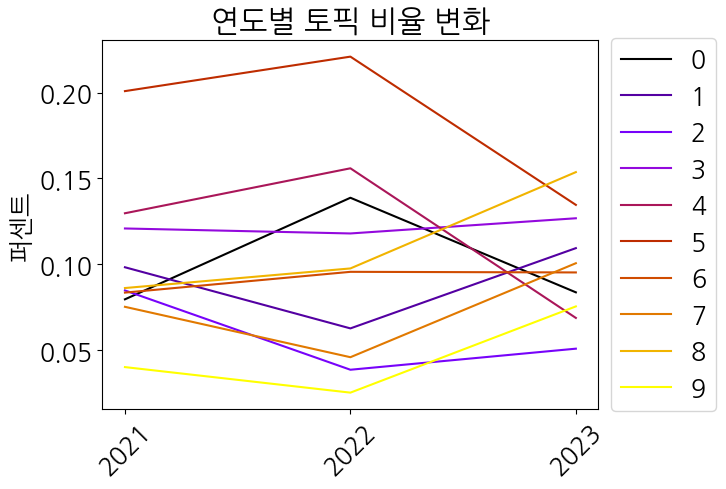

In [ ]:
f = plt.figure()
plt.title('연도별 토픽 비율 변화', color='black')
topic_dist_by_time.plot(ax=f.gca(),colormap='gnuplot')
plt.xticks(np.array(range(2021,2024)),rotation=45)
ax=f.gca()
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
ax.set_ylabel('퍼센트')
plt.show()

### 3. DMR (Dirichlet Multinomial Regression)
"언론사 성향에 따른 청년 담론의 차이"

##### metadata 설정(명목변수) : 언론사 (진보 vs 보수)

In [ ]:
df['언론사'].value_counts()

언론사
경향신문    1152
중앙일보     946
동아일보     930
조선일보     669
한겨레      596
Name: count, dtype: int64

In [ ]:
# 언론사_성향 컬럼 추가
df['언론사_성향'] = pd.Series()

In [ ]:
df['언론사_성향'][df['언론사'].isin(['조선일보','중앙일보','동아일보'])] = '보수'
df['언론사_성향'][df['언론사'].isin(['경향신문','한겨레'])] = '진보'

<ipython-input-38-963a183d179b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['언론사_성향'][df['언론사'].isin(['조선일보','중앙일보','동아일보'])] = '보수'
<ipython-input-38-963a183d179b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['언론사_성향'][df['언론사'].isin(['경향신문','한겨레'])] = '진보'


In [ ]:
df['언론사_성향'].value_counts()

언론사_성향
보수    2545
진보    1748
Name: count, dtype: int64

##### 모델 초기화

In [ ]:
DMR = tp.DMRModel(k=10,min_df=10,tw=tp.TermWeight.PMI,rm_top=3, seed=2021)

##### 빈 모델에 토큰 리스트와 명목변수 넣어주기

In [ ]:
token_politics_dict = df[['token','언론사_성향']].to_dict('index')

In [ ]:
for k in tqdm(token_politics_dict.keys()):
    DMR.add_doc(token_politics_dict[k]['token'],token_politics_dict[k]['언론사_성향'])

  0%|          | 0/4293 [00:00<?, ?it/s]

##### 모델 학습

In [ ]:
DMR.train(0)

<ipython-input-43-1ef95a5c1224>:1: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DMR.train(0)


In [ ]:
# 한번에 20회씩 총 500회 학습
print('Num docs:', len(DMR.docs), ', Vocab size:', DMR.num_vocabs, ', Num words:', DMR.num_words)
print('Removed top words:', DMR.removed_top_words)
print('Training...', file=sys.stderr, flush=True)
for i in range(0, 500, 20):
    DMR.train(20)
    print('Iteration: {}\tLog-likelihood: {}'.format(i, DMR.ll_per_word))

Training...


Num docs: 4293 , Vocab size: 7143 , Num words: 697124
Removed top words: ['청년', '지원', '청년들']


<ipython-input-44-5b9d3587116c>:6: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  DMR.train(20)


Iteration: 0	Log-likelihood: -8.165043631617058
Iteration: 20	Log-likelihood: -8.035162959769902
Iteration: 40	Log-likelihood: -7.9829339001451
Iteration: 60	Log-likelihood: -7.945229298163626
Iteration: 80	Log-likelihood: -7.9233531205715115
Iteration: 100	Log-likelihood: -7.904301112363024
Iteration: 120	Log-likelihood: -7.889283518339791
Iteration: 140	Log-likelihood: -7.877966678995711
Iteration: 160	Log-likelihood: -7.870051715966275
Iteration: 180	Log-likelihood: -7.862006335334211
Iteration: 200	Log-likelihood: -7.854980061625726
Iteration: 220	Log-likelihood: -7.848222796511378
Iteration: 240	Log-likelihood: -7.844349149822763
Iteration: 260	Log-likelihood: -7.841075949079449
Iteration: 280	Log-likelihood: -7.837576987677655
Iteration: 300	Log-likelihood: -7.83509242296321
Iteration: 320	Log-likelihood: -7.8326407564340075
Iteration: 340	Log-likelihood: -7.829561960855195
Iteration: 360	Log-likelihood: -7.8274655060057166
Iteration: 380	Log-likelihood: -7.8266377543565415
Itera

##### 토픽별 TopN 단어 확인

In [ ]:
for i in range(DMR.k):
    res = DMR.get_topic_words(i, top_n=10)
    print('Topic #{}'.format(i), end='\t')
    print(', '.join(w for w, p in res))

Topic #0	일자리, 채용, 취업, 고용, 노조, 노동자, 기업, 중소기업, 임금, 노동
Topic #1	A씨, 경찰, 요금, 사고, 혐의, 사건, 피해자, 아들, 아버지, 김씨
Topic #2	지역, 창업, 교육, 기업, 프로그램, 취업, 사업, 인재, 운영, 조성
Topic #3	사업, 예산, 서울시, 신청, 지급, 소득, 경기도, 자립, 정책, 최대
Topic #4	가입, 취업자, 증가, 금리, 인구, 감소, 금융, 대출, 은행, 소득
Topic #5	주택, 가구, 공급, 대출, 전세, 신혼부부, 임대, 보증금, 월세, 주거
Topic #6	후보, 의원, 국민, 대표, 정치, 민주당, 대통령, 대선, 선거, 위원장
Topic #7	중국, 한국, 일본, 미국, 기후, 북한, 대통령, 러시아, 시위, 국가
Topic #8	여성, 사회, 세대, 은둔, 고립, 생각, 가족, 연금, 남성, 결혼
Topic #9	작가, 작품, 문화, 대회, 한국, 영화, 전시, 행사, 예술, 공연


##### 토픽 이름 자동으로 붙이기 (참고용)

In [ ]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf=10, min_df=10, max_len=5, max_cand=10000)
cands = extractor.extract(DMR)

labeler = tp.label.FoRelevance(DMR, cands, min_df=10, smoothing=1e-2, mu=0.25)
for k in range(DMR.k):
    print("== Topic #{} ==".format(k))
    print("Labels:", ', '.join(label for label, score in labeler.get_topic_labels(k, top_n=5)))
    for word, prob in DMR.get_topic_words(k, top_n=10):
        print(word, prob, sep='\t')
    print()

== Topic #0 ==
Labels: 임금, 사무직, 노동 시장, 정규직, 한국노동연구원
일자리	0.027146609500050545
채용	0.02044030651450157
취업	0.017744997516274452
고용	0.016554659232497215
노조	0.01418516505509615
노동자	0.013169093988835812
기업	0.010406563058495522
중소기업	0.010352316312491894
임금	0.01033306960016489
노동	0.010103740729391575

== Topic #1 ==
Labels: 경찰, A씨, 선고, 혐의, 징역
A씨	0.016258342191576958
경찰	0.013205192051827908
요금	0.010528096929192543
사고	0.009482442401349545
혐의	0.007878688164055347
사건	0.007407762110233307
피해자	0.007060192059725523
아들	0.006848593708127737
아버지	0.00631573423743248
김씨	0.006066246423870325

== Topic #2 ==
Labels: 우수, 육성, 창업, 스마트, 양성
지역	0.01315667200833559
창업	0.012745421379804611
교육	0.010007164441049099
기업	0.00988372229039669
프로그램	0.008693654090166092
취업	0.007341835647821426
사업	0.006853271741420031
인재	0.005706318188458681
운영	0.005541384220123291
조성	0.0054639107547700405

== Topic #3 ==
Labels: 중위 소득, 원씩, 중위, 대상자, 지급
사업	0.015372357331216335
예산	0.01508342381566763
서울시	0.011201932094991207
신청	0.00913379993289

##### metadata에 따른 토픽 분포 대조
https://github.com/bab2min/tomotopy/blob/main/examples/dmr_plot.py

In [ ]:
DMR.metadata_dict

['보수', '진보']

명목변수 별 토픽 비율
보수 [0.07332216 0.06039683 0.14543377 0.10722902 0.09488709 0.04470907
 0.11899648 0.08194339 0.15541728 0.11766499] 

진보 [0.07970563 0.05016028 0.1405405  0.16591123 0.0993643  0.06233254
 0.10510276 0.06630553 0.1494188  0.08115847] 



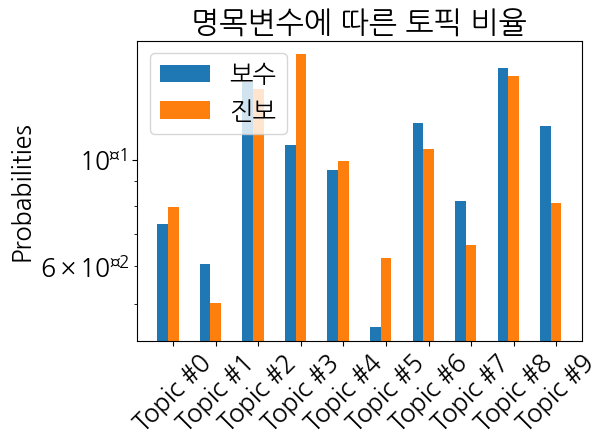

In [ ]:
# calculate topic distribution for each metadata using softmax
probs = np.exp(DMR.lambdas - DMR.lambdas.max(axis=0))
probs /= probs.sum(axis=0)

print('명목변수 별 토픽 비율')
for f, metadata_name in enumerate(DMR.metadata_dict):
    print(metadata_name, probs[:, f], '\n')

x = np.arange(DMR.k)
width = 1 / (DMR.f + 2)

fig, ax = plt.subplots()
for f, metadata_name in enumerate(DMR.metadata_dict):
    ax.bar(x + width * (f - DMR.f / 2), probs[:, f], width, label=DMR.metadata_dict[f])

ax.set_ylabel('Probabilities')
ax.set_yscale('log')
ax.set_title('명목변수에 따른 토픽 비율')
ax.set_xticks(x)
ax.set_xticklabels(['Topic #{}'.format(k) for k in range(DMR.k)],rotation=45) # x축 라벨 45도로 회전
ax.legend()

fig.tight_layout()
plt.show()

### 오늘의 과제 : 여러분이 직접 빅카인즈에서 파일 다운해서 분석진행하기